In [1]:
%matplotlib inline
import numpy as np
import os
from datavyz import ges as ge

# Simulations with synaptic mechanisms only

The data are generated by looping over:

    - background activity levels
    - seeds for the background activity
    - stimulus intensity (the number of synapses recruited)
    - the stimulus properties (here the seed that shape the random synaptic sequence).

This loop over four conditions is implemented in the bash script: [./bash/BG.sh](./bash/BG.sh)

You can run it with:

> sh bash/BG.sh

## Raw responses

### Load data from individual sims (i.e. one specific background seed, one specific stimulus seed)

In [2]:
%run bash/load_batch_simulations.py
RESP_PASSIVE = build_full_dataset(key='passive',
                                  folder = os.path.join('data', 'bg-modul'),
                                  # folder = 'D:',
                                  filename_only=True)

In [344]:
# plotting function in script:
%run plots/plot_single_sim_bg_data.py

<Figure size 432x288 with 0 Axes>

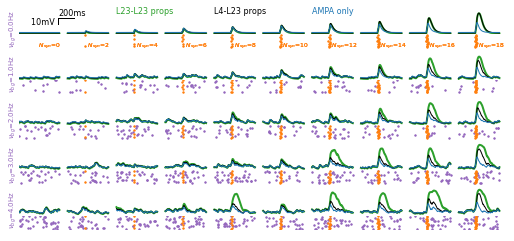

In [4]:
props = {'NSTIMs':None,
         'alphaZn':[0., 0.45],
         'syn_location':1, 'stimseeds':[1], 'seeds':[0],
         'with_ampa_only':True,
         'LWS':[2,1,1], 'COLORS':[ge.green, 'k'],
         'LABELS':['L23-L23 props', 'L4-L23 props', 'AMPA only'],
         'bar_scale_args':dict(Xbar = 200, Xbar_label='200ms', Ybar = 10, Ybar_label='10mV ', loc=(0.08,0.6), orientation='right-bottom'),
         'figsize':(2.8,.1), 'view':[-200,300], 'shift':100, 'VLIM':[-76,-30]}
fig = plot_single_sim_bg_data(RESP_PASSIVE, ge,
                              bg_levels=[0,1,2,3,4], **props)
fig.savefig(os.path.join('figures', 'bg-dep-passive-full-example-single-trial.png'), dpi=300)

#### shifting synaptic locations and seeds (background & stimulus)

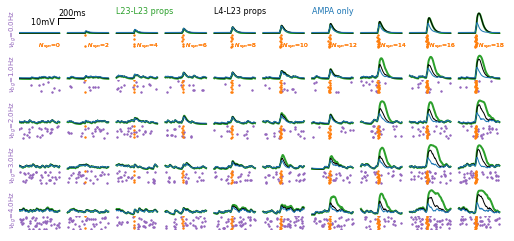

In [67]:
props['syn_location'] = 2
props['stimseeds'] = [1]
props['seeds'] = [2]
fig = plot_single_sim_bg_data(RESP_PASSIVE, ge,
                              bg_levels=[0,1,2,3,4], **props)

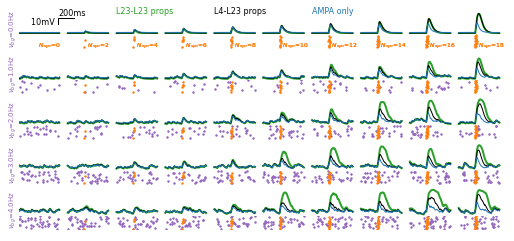

In [68]:
props['syn_location'] = 5
props['stimseeds'] = [2]
props['seeds'] = [7]
fig = plot_single_sim_bg_data(RESP_PASSIVE, ge,
                              bg_levels=[0,1,2,3,4], **props)

### Average data (from multiple synaptic locations, background activity and stimulus identity)

In [69]:
%run bash/load_batch_simulations.py
RESP_PASSIVE_PER_STIM = build_full_dataset_per_stim(key='passive',
                                                    with_Vm_trace=True,
                                                    folder = os.path.join('data', 'bg-modul'),
                                                    # folder='D:',
                                                    filename_only=True)

<Figure size 432x288 with 0 Axes>

### Synaptic location 1

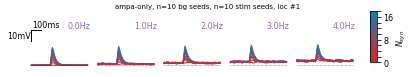

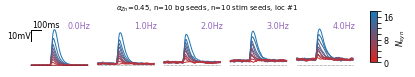

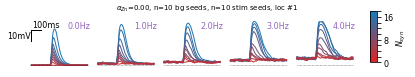

In [70]:
%run plots/show_trial_average_responses.py
props = {'VLIM':[-76,-33], 'syn_location':1}
show_trial_average_responses(RESP_PASSIVE_PER_STIM, 'ampa-only', **props)
show_trial_average_responses(RESP_PASSIVE_PER_STIM, alphaZn=0.45, **props)
show_trial_average_responses(RESP_PASSIVE_PER_STIM, alphaZn=0., **props)

### Synaptic location 2

(N.B. the waveforms are close to identical because we average over the same background and stimulus seeds, the synaptic locations will therefore only vary the amplitude of the waveform but not so muchits temporal profile)

RUNNING: inkscape figures/bg-trial-average.svg --export-area-page --export-background="white" --export-type=png --export-filename="figures/bg-trial-average.png" --export-dpi=300
[ok] figure successfully exported as: figures/bg-trial-average.png


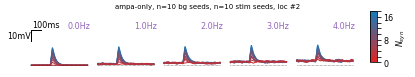

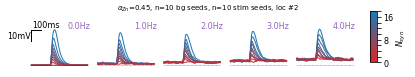

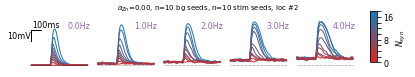

In [352]:
%run plots/show_trial_average_responses.py
props = {'VLIM':[-76,-33], 'syn_location':2}
fig1 = show_trial_average_responses(RESP_PASSIVE_PER_STIM, 'ampa-only', **props)
fig2 = show_trial_average_responses(RESP_PASSIVE_PER_STIM, alphaZn=0.45, **props)
fig3 = show_trial_average_responses(RESP_PASSIVE_PER_STIM, alphaZn=0., **props)
ge.multipanel_figure([[fig1],[fig2], [fig3]],
                     LABELS=[['a'],['b'],['c']],
                     width='double-column', # can also be "single-column" or "double-column"
                     fig_name='figures/bg-trial-average.svg',
                     grid=False, # switch to True to get the Grid position and pricesely place labels if necessary
                     export_to_png=True,
                     autoposition=True)

### Computing input-ouput curves ()

5


C:\Users\yann.zerlaut\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


5


5


Text(0.5, 0.98, '                              syn loc. #5')

<Figure size 432x288 with 0 Axes>

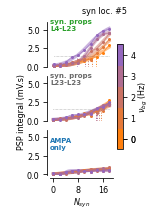

In [367]:
%run plots/show_trial_average_responses.py
props = {'syn_location':5, 'thresholds':{'Proba':1.5}} # 'VLIM':[-76,0], 
AMPA = get_trial_average_responses(RESP_PASSIVE_PER_STIM, 'ampa-only', **props)
FREE = get_trial_average_responses(RESP_PASSIVE_PER_STIM,  alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_PASSIVE_PER_STIM,  alphaZn=0., **props)
fig_BG11 = show_response_bg_dep(FREE, CHELATED, AMPA,
                                method='Integral', ge=ge,
                                ylim=[-0.1,6], yscale='lin',
                                # xlim=[0,19],
                                # BG_levels=[0,1.,2,3.],
                                crossing=props['thresholds']['Proba'])#.savefig('figures/fig22.svg')
fig_BG11.suptitle(30*' '+'syn loc. #%i' % props['syn_location'], size=8)

4


C:\Users\yann.zerlaut\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


4


4


Text(0.5, 0.98, '                              syn loc. #4')

<Figure size 432x288 with 0 Axes>

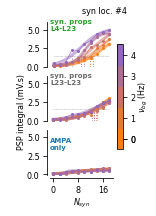

In [372]:
%run plots/show_trial_average_responses.py
props = {'syn_location':4, 'thresholds':{'Proba':1.5}} # 'VLIM':[-76,0], 
AMPA = get_trial_average_responses(RESP_PASSIVE_PER_STIM, 'ampa-only', **props)
FREE = get_trial_average_responses(RESP_PASSIVE_PER_STIM,  alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_PASSIVE_PER_STIM,  alphaZn=0., **props)
fig_BG12 = show_response_bg_dep(FREE, CHELATED, AMPA,
                                method='Integral', ge=ge,
                                ylim=[-0.1,6], yscale='lin',
                                # xlim=[0,19],
                                # BG_levels=[0,1.,2,3.],
                                crossing=props['thresholds']['Proba'])#.savefig('figures/fig22.svg')
fig_BG12.suptitle(30*' '+'syn loc. #%i' % props['syn_location'], size=8)

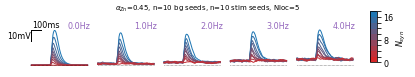

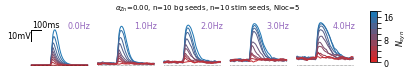

In [74]:
props = {'VLIM':[-76,-33], 'syn_location':'all'}
show_trial_average_responses(RESP_PASSIVE_PER_STIM, alphaZn=0.45, **props)
show_trial_average_responses(RESP_PASSIVE_PER_STIM, alphaZn=0., **props)

## Quantifying stimulus encoding (independently and across the background activity levels)

In [319]:
from sklearn.neighbors import NearestNeighbors

def build_training_set(RESP_PER_STIM, resp='ampa-only',
                       stimseed='all',
                       N=None, # useless
                       bg_level='all',
                       syn_location='all',
                       verbose=True,
                       window=[-100, 300]):
    if resp=='ampa-only':
        cond = (RESP_PER_STIM['ampa_only']==True)
    elif resp=='L23':
        cond = (RESP_PER_STIM['ampa_only']==False) & (RESP_PER_STIM['alphaZn']==0.45)
    elif resp=='L4':
        cond = (RESP_PER_STIM['ampa_only']==False) & (RESP_PER_STIM['alphaZn']==0.)
        
    if bg_level!='all':
        cond = cond & (RESP_PER_STIM['bg_level']==bg_level)
    if syn_location!='all':
        cond = cond & (RESP_PER_STIM['syn_location']==syn_location)
    if stimseed!='all':
        cond = cond & (RESP_PER_STIM['stimseed']==stimseed)
        
    nstims = np.unique(RESP_PER_STIM['nstim'][cond])

    tcond = (RESP_PASSIVE_PER_STIM['t']>RESP_PASSIVE_PER_STIM['stim_delay']+window[0]) &\
        (RESP_PASSIVE_PER_STIM['t']<RESP_PASSIVE_PER_STIM['stim_delay']+window[1])
    
    Vm_traces = []
    for i, nstim in enumerate(nstims):
        cond1 = cond & (RESP_PER_STIM['nstim']==nstim)
        Vm_traces.append(np.mean(RESP_PASSIVE_PER_STIM['Vm'][cond1], axis=0)[tcond])

    return Vm_traces


def build_test_set(RESP_PER_STIM, resp='ampa-only',
                   N=100,
                   stimseed='all',
                   bg_level='all',
                   syn_location='all',
                   window=None, verbose=True):
    
    if resp=='ampa-only':
        cond = (RESP_PER_STIM['ampa_only']==True)
    elif resp=='L23':
        cond = (RESP_PER_STIM['ampa_only']==False) & (RESP_PER_STIM['alphaZn']==0.45)
    elif resp=='L4':
        cond = (RESP_PER_STIM['ampa_only']==False) & (RESP_PER_STIM['alphaZn']==0.)
        
    if stimseed!='all':
        cond = cond & (RESP_PER_STIM['stimseed']==stimseed)
    if bg_level!='all':
        cond = cond & (RESP_PER_STIM['bg_level']==bg_level)

    Vm_traces, true_ID = [], []
    tcond = (RESP_PASSIVE_PER_STIM['t']>RESP_PASSIVE_PER_STIM['stim_delay']+window[0]) &\
        (RESP_PASSIVE_PER_STIM['t']<RESP_PASSIVE_PER_STIM['stim_delay']+window[1])
    
    if syn_location!='all':
        
        cond = cond & (RESP_PER_STIM['syn_location']==syn_location)
        nstims = np.sort(np.unique(RESP_PER_STIM['nstim'][cond]))
        icond = np.arange(len(RESP_PER_STIM['nstim']))[cond]

        if len(icond)<N:
            N = int(len(icond)/2)
            print('N=', N)

        for n, i in enumerate(np.random.choice(icond, N, replace=False)):
            
           true_ID.append(np.argwhere(RESP_PER_STIM['nstim'][i]==nstims)[0][0])
           Vm_traces.append(RESP_PER_STIM['Vm'][i][tcond])
    else:
        syn_locations = np.unique(RESP_PER_STIM['syn_location'])
        nstims = np.sort(np.unique(RESP_PER_STIM['nstim'][cond]))
        i=0
        # we force that a single realisation has the sum of all location
        while i<N:
            ns = np.random.choice(nstims, 1) # we pick a given level
            vm_trace = []
            for s in syn_locations:
                cond1 = cond & (RESP_PER_STIM['syn_location']==s) & (RESP_PER_STIM['nstim']==ns)
                i0 = np.random.choice(np.arange(len(RESP_PER_STIM['nstim']))[cond1], 1)[0]
                vm_trace.append(RESP_PER_STIM['Vm'][i0][tcond])
                
            true_ID.append(np.argwhere(ns==nstims)[0][0])
            Vm_traces.append(np.mean(vm_trace, axis=0))
            i+=1
        
    return Vm_traces, true_ID

def compute_decoding_accuracy(RESP_PASSIVE_PER_STIM, props,
                              verbose=False):
    
    Vm_traces_training = build_training_set(RESP_PASSIVE_PER_STIM, **props)
    nbrs = NearestNeighbors(n_neighbors=1,
                            algorithm='ball_tree').fit(Vm_traces_training)
    Vm_traces_test, test_ID = build_test_set(RESP_PASSIVE_PER_STIM, **props)

    _, pred = nbrs.kneighbors(Vm_traces_test)
    val = test_ID-pred.flatten()
    if verbose:
        print('For the properties %s' % props)
        print('--> Decoder accuracy: %.2f %%    (chance level= %.0f%%)' % (100*np.sum(val==0)/len(val), 100/len(Vm_traces_training)))
    return 100*np.sum(val==0)/len(val)


props = {'bg_level':'all',
         'syn_location':'all',
         'stimseed':30,
         'resp':'L23',
         'window':[-100, 300],
         'N':200}
compute_decoding_accuracy(RESP_PASSIVE_PER_STIM, props, verbose=True)


For the properties {'bg_level': 'all', 'syn_location': 'all', 'stimseed': 30, 'resp': 'L23', 'window': [-100, 300], 'N': 200}
--> Decoder accuracy: 67.00 %    (chance level= 10%)


67.0

<Figure size 432x288 with 0 Axes>

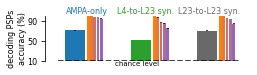

In [369]:
%run plots/decoding.py

props = {'bg_level':'all',
         'syn_location':'all',
         'stimseed':'all',
         'resp':'L23',
         'window':[-100, 300],
         'N':1000}

figBG13, ax = ge.figure(figsize=(1.8,1), left=0.6, bottom=0.3, top=0.6)
cmap = ge.get_linear_colormap(ge.orange, ge.purple)
stimseeds = np.unique(RESP_ACTIVE_PER_STIM['stimseed'])

for iax, color, resp, label in zip(range(3),
                            [ge.blue, ge.green, ge.dimgrey],
                            ['ampa-only', 'L4', 'L23'],
                       ['AMPA-only', 'L4-to-L23 syn.', 'L23-to-L23 syn.']):
    props['resp'] = resp

    # start with all levels
    props['bg_level'] = 'all'
    X = []
    for ss in stimseeds:
        props['stimseed'] = ss
        X.append(compute_decoding_accuracy(RESP_PASSIVE_PER_STIM, props))
    # ax.bar([iax], [np.mean(X)], y=[np.std(np)], width=.3, color=color)
    ax.bar([iax], [np.mean(X)], yerr=[np.std(X)], width=.3, color=color)

    for b, bg in enumerate(np.unique(RESP_PASSIVE_PER_STIM['bg_level'])):
        props['bg_level'] = bg
        X = []
        for ss in stimseeds:
            props['stimseed'] = ss
            X.append(compute_decoding_accuracy(RESP_PASSIVE_PER_STIM, props))
        ax.bar([iax+.2+b*0.05], [np.mean(X)], yerr=[np.std(X)], width=.04,
               color=cmap(b/4))

    ge.annotate(ax, label, (iax+.5, 100.),
                xycoords='data', color=color, ha='right')
    
ge.annotate(ax, 'chance level', (0.6, 10.),
            xycoords='data', va='top', size='small')
ax.plot([-0.25, 2.5], [10, 10], 'k--')

ge.set_plot(ax, ['left'], ylim=[9,100], yticks=[10, 50, 90],
            ylabel='decoding PSPs\naccuracy (%)')
#fig.savefig('figures/decoding-passive.png', dpi=300)

In [373]:
ge.multipanel_figure([[fig_BG11, fig_BG12],[figBG13]],
                     LABELS=[['a','b'],['c']],
                     width='single-column', # can also be "single-column" or "double-column"
                     fig_name='figures/bg-passive-analysis.svg',
                     grid=False, # switch to True to get the Grid position and pricesely place labels if necessary
                     export_to_png=True,
                     autoposition=True)

RUNNING: inkscape figures/bg-passive-analysis.svg --export-area-page --export-background="white" --export-type=png --export-filename="figures/bg-passive-analysis.png" --export-dpi=300
[ok] figure successfully exported as: figures/bg-passive-analysis.png


# Simulations with active mechanisms (spikes, Ca-dynamics, ...)

The data are generated by looping over:

    - background activity levels
    - seeds for the background activity
    - stimulus intensity (the number of synapses recruited)
    - the stimulus properties (here the seed that shape the random synaptic sequence).

This loop over four conditions is implemented in the bash script: [./bash/BG.sh](./bash/BG.sh)

You can run it with:

> sh bash/BG-active.sh

In [16]:
%run bash/load_batch_simulations.py
RESP_ACTIVE = build_full_dataset(key='active',
                                 folder = os.path.join('data', 'bg-modul'),
                                 filename_only=True)

<Figure size 432x288 with 0 Axes>

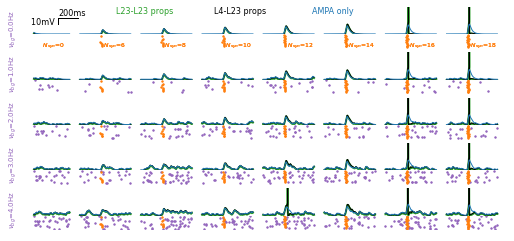

In [17]:
%run plots/plot_single_sim_bg_data.py
# from datavyz import graph_env_dark_notebook as ge
# props = {'NSTIMs':None,#[0, 6, 8, 10, 12, 14],
#          'alphaZn':[0.45, 0.45],
#          'syn_location':5, 'stimseeds':[0], 'figsize':(2.5,.1), 'view':[-300,450], 'shift':100}

%run plots/plot_single_sim_bg_data.py
props = {'NSTIMs':None,
         'alphaZn':[0.45, 0.45],
         'syn_location':5, 'stimseeds':[0], 'seeds':[0],
         'with_ampa_only':True,
         'LWS':[2,1,1], 'COLORS':[ge.green, 'k'],
         'LABELS':['L23-L23 props', 'L4-L23 props', 'AMPA only'],
         'bar_scale_args':dict(Xbar = 200, Xbar_label='200ms', Ybar = 10, Ybar_label='10mV ', loc=(0.08,0.6), orientation='right-bottom'),
         'figsize':(2.8,.1), 'view':[-200,300], 'shift':100, 'VLIM':[-76,-30]}

fig = plot_single_sim_bg_data(RESP_ACTIVE, ge, bg_levels=[0.,1,2,3,4], **props)
fig.savefig(os.path.join('figures', 'bg-dep-active-full-example-single-trial.png'), dpi=300)

In [18]:
%run bash/load_batch_simulations.py
RESP_ACTIVE_PER_STIM = build_full_dataset_per_stim(key='active',
                                                   with_Vm_trace=True,
                                                   folder = os.path.join('data', 'bg-modul'),
                                                   # folder='D:',
                                                   filename_only=True)


<Figure size 432x288 with 0 Axes>

5
5


<Figure size 432x288 with 0 Axes>

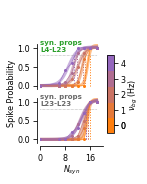

In [58]:
%run plots/show_trial_average_responses.py
props = {'syn_location':5, 'thresholds':{'Proba':0.8}} # 'VLIM':[-76,0], 
FREE = get_trial_average_responses(RESP_ACTIVE_PER_STIM,
                                   alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_ACTIVE_PER_STIM,
                                       alphaZn=0., **props)
fig_BG12 = show_response_bg_dep(FREE, CHELATED, method='Proba', ge=ge,
                                ylim=[-0.1,1.1],
                                xlim=[0,20],
                                # xlim=[6,18],
                                # BG_levels=[0,1.,2],
                                crossing=props['thresholds']['Proba'])#.savefig('figures/fig22.svg')

1
1


2
2


3
3


4
4


5
5


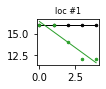

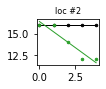

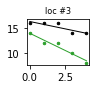

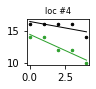

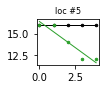

In [29]:
WITH_PLOT = True
SLOPES = {'free':[], 'chelated':[]}
for i in np.unique(RESP_ACTIVE_PER_STIM['syn_location']):
    props = {'syn_location':i, 'thresholds':{'Proba':0.8}} # 'VLIM':[-76,0], 
    FREE = get_trial_average_responses(RESP_ACTIVE_PER_STIM, alphaZn=0.45, **props)
    CHELATED = get_trial_average_responses(RESP_ACTIVE_PER_STIM, alphaZn=0., **props)
    if WITH_PLOT:
        fig, ax= ge.figure()
    for C, color, key in zip([FREE, CHELATED], ['k', ge.green], ['free', 'chelated']):
        x = [C[i]['bg_level'] for i in range(len(C))]
        y = [C[i]['Proba-threshold'] for i in range(len(C))]
        lin = np.polyfit(x, y, 1)
        SLOPES[key].append(-lin[0])
        if WITH_PLOT:
            ge.scatter(x, y, color=color, ax=ax, no_set=True)
            ge.plot(x, np.polyval(lin, x), color=color, ax=ax, no_set=True)
            ge.title(ax, 'loc #%i' % i)

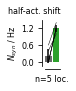

In [30]:
Fig2inset, ax, pval = ge.related_samples_two_conditions_comparison(np.array(SLOPES['free']),
                                                                   np.array(SLOPES['chelated']),
                                                                   with_annotation=False,
                                                                   lw=.5,
                                                                   color1=ge.dimgrey, color2=ge.green,
                                                                   ylabel='$N_{syn}$ / Hz',
                                                                   xticks=[],#[0, 1],
                                                                   fig_args=dict(right=4., figsize=(.5,1.), left=1.2, top=1.5))
ge.annotate(ax, 'half-act. shift', (1., 1.1), ha='right')
ge.annotate(ax, 'n=%i loc.' % len(SLOPES['free']) , (-.6, -.4))
Fig2inset.savefig('figures/fig22.svg')

In [54]:
RESP_ACTIVE_PER_STIM

{'Vm': array([[-75.        , -75.07386586, -75.11330787, ..., -77.43970663,
         -77.43969019, -77.43967378],
        [-77.43965735, -77.43964097, -77.43962458, ..., -77.43651254,
         -77.43649915, -77.43648581],
        [-77.43647251, -77.43645919, -77.43644588, ..., -77.44232352,
         -77.44230541, -77.44228731],
        ...,
        [-71.77979987, -71.81482268, -71.85026828, ..., -73.88914602,
         -73.88932676, -73.86151911],
        [-73.81491463, -73.75760535, -73.69550703, ..., -75.39306446,
         -75.41182029, -75.43044805],
        [-75.44894675, -75.46731552, -75.48555364, ..., -74.34879846,
         -74.2956628 , -74.24765169]]),
 'Vm_peak': array([-77.25232729, -69.60360427, -67.25304813, ...,  43.86865552,
         33.08862091,  44.64364919]),
 'Vm_integral': array([-0.47863365,  0.36729689,  0.48471762, ..., -0.64515222,
         0.16450668,  1.95219392]),
 'Vm_baseline': array([-76.52791892, -77.43975687, -77.43654189, ..., -72.15832503,
        -72.0

In [142]:
def show_trial_average_responses(RESP_PER_STIM, resp='', 
                                 alphaZn=0., 
                                 VLIM=None,
                                 syn_location='all',
                                 window=[-200,400]):

    if resp=='ampa-only':
        cond = (RESP_PER_STIM['ampa_only']==True)
    else:
        cond = (RESP_PER_STIM['ampa_only']==False) & (RESP_PER_STIM['alphaZn']==alphaZn)
        resp = '$\\alpha_{Zn}$=%.2f' % alphaZn
    if syn_location is not 'all':
        cond = cond & (RESP_PER_STIM['syn_location']==syn_location)
        sloc = 'loc #%i' % syn_location
    else:
        sloc = 'Nloc=%i' % len(np.unique(RESP_PER_STIM['syn_location']))
        
    bg_levels = np.unique(RESP_PER_STIM['bg_level'])
    fig, AX = ge.figure(axes=(len(bg_levels),1), wspace=0.1, right=1.3)
    
    fig.suptitle('%s, n=%i bg seeds, n=%i stim seeds, %s' % (resp,
                                                    len(np.unique(RESP_PER_STIM['seed'])),
                                                    len(np.unique(RESP_PER_STIM['seed'])), # STIM SEED HERE !
                                                    sloc))
    t = RESP_PER_STIM['t']
    ylim, ylim2 = [np.inf, -np.inf], [np.inf, -np.inf]
    for ibg, bg in enumerate(bg_levels):
        for istim, nstim in enumerate(np.unique(RESP_PER_STIM['nstim'])[::-1]):
            # raw responses
            scond = cond &\
                (RESP_PER_STIM['nstim']==nstim) & (RESP_PER_STIM['bg_level']==bg)
    
            tcond = (t>=RESP_PER_STIM['stim_delay']+window[0]) & (t<RESP_PER_STIM['stim_delay']+window[1])
            y0 = np.mean([RESP_PER_STIM['Vm'][i] for i, s in enumerate(scond) if s], axis=0)
            AX[ibg].plot(t[tcond], y0[tcond],lw=1,
                    color=ge.red_to_blue(1-istim/len(np.unique(RESP_PER_STIM['nstim']))))
            ylim = [-76, max([ylim[1],y0.max()])]
        AX[ibg].plot([t[tcond][0],t[tcond][-1]], -75*np.ones(2), 'k:', lw=0.5)
        ge.annotate(AX[ibg],'%.1fHz'%bg,(1,1),color=ge.purple,ha='right',va='top')
        
    for ibg, bg in enumerate(bg_levels):
        if VLIM is not None:
            ylim = VLIM
        ge.set_plot(AX[ibg], [], ylim=ylim)
    ge.draw_bar_scales(AX[0], Xbar = 200, Xbar_label='200ms',
                              Ybar = 10, Ybar_label='10mV',
                              loc=(0.05,.8), orientation='right-bottom')
    ge.bar_legend(fig, X=np.unique(RESP_PER_STIM['nstim']),
                  bounds=[0, np.unique(RESP_PER_STIM['nstim'])[-1]],
                  ticks_labels=['%i' % x if i%4==0 else '' for i, x in enumerate(np.unique(RESP_PER_STIM['nstim']))],
                  inset=dict(rect=[.999,.4,.016, .5]),
                  colormap=ge.red_to_blue, label='$N_{syn}$')


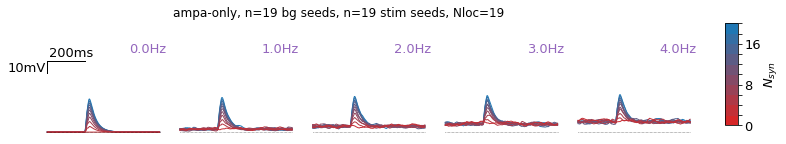

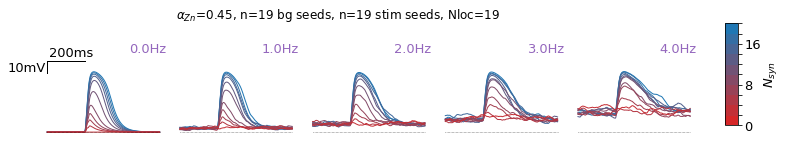

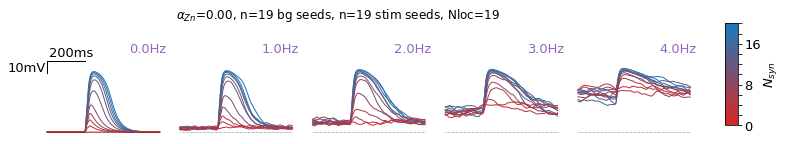

In [143]:
%run plots/show_trial_average_responses.py
props = {'VLIM':[-76,0], 'syn_location':'all'}
show_trial_average_responses(RESP_PER_STIM, 'ampa-only', **props)
show_trial_average_responses(RESP_PER_STIM, alphaZn=0.45, **props)
show_trial_average_responses(RESP_PER_STIM, alphaZn=0., **props)

In [144]:
def get_trial_average_responses(RESP_PER_STIM, resp='', 
                                alphaZn=0., 
                                syn_location='all',
                                baseline_window=[-100,0],
                                peak_window=[0,500],
                                integral_window=[0,500]):

    if resp=='ampa-only':
        cond = (RESP_PER_STIM['ampa_only']==True)
    else:
        cond = (RESP_PER_STIM['ampa_only']==False) & (RESP_PER_STIM['alphaZn']==alphaZn)
        resp = '$\\alpha_{Zn}$=%.2f' % alphaZn
    if syn_location is not 'all':
        cond = cond & (RESP_PER_STIM['syn_location']==syn_location)
        sloc = 'loc #%i' % syn_location
    else:
        sloc = 'Nloc=%i' % len(np.unique(RESP_PER_STIM['syn_location']))
        
    bg_levels = np.unique(RESP_PER_STIM['bg_level'])

    t = RESP_PER_STIM['t']

    RESP = []
    
    for ibg, bg in enumerate(bg_levels):
        RESP.append({'nstims':[], 'Peak':[], 'Integral':[], 'Freq':[], 'bg_level':bg})
        for k in ['Peak', 'Integral', 'Freq']:
            RESP[-1][k], RESP[-1]['min'+k], RESP[-1]['max'+k] = [], [], []
            
        for istim, nstim in enumerate(np.unique(RESP_PER_STIM['nstim'])):
           
            RESP[ibg]['nstims'].append(nstim)
            scond = cond &\
                (RESP_PER_STIM['nstim']==nstim) & (RESP_PER_STIM['bg_level']==bg)
            # trial average
            y = np.mean([RESP_PER_STIM['Vm'][i] for i, s in enumerate(scond) if s], axis=0)
            sy = np.std([RESP_PER_STIM['Vm'][i] for i, s in enumerate(scond) if s], axis=0)
            # baseline
            BSLcond = (t>=RESP_PER_STIM['stim_delay']+baseline_window[0]) &\
                            (t<RESP_PER_STIM['stim_delay']+baseline_window[1])
            BSL = np.mean(y[BSLcond])
            # peak depol
            PEAKcond = (t>=RESP_PER_STIM['stim_delay']+peak_window[0]) &\
                            (t<RESP_PER_STIM['stim_delay']+peak_window[1])
            RESP[ibg]['Peak'].append(np.max(y[PEAKcond])-BSL)
            RESP[ibg]['minPeak'].append(np.max(y[PEAKcond]-sy[PEAKcond])-BSL)
            RESP[ibg]['maxPeak'].append(np.max(y[PEAKcond]+sy[PEAKcond])-BSL)
            # depol integral
            INTcond = (t>=RESP_PER_STIM['stim_delay']+integral_window[0]) &\
                            (t<RESP_PER_STIM['stim_delay']+integral_window[1])
            RESP[ibg]['Integral'].append(np.trapz(y[INTcond]-BSL, t[INTcond])/1e3)
            RESP[ibg]['minIntegral'].append(np.trapz(y[INTcond]-sy[PEAKcond]-BSL, t[INTcond])/1e3)
            RESP[ibg]['maxIntegral'].append(np.trapz(y[INTcond]+sy[PEAKcond]-BSL, t[INTcond])/1e3)
            RESP[ibg]['Freq'].append(np.mean([RESP_PER_STIM['freq'][i] for i, s in enumerate(scond) if s]))
            RESP[ibg]['Proba'].append(np.mean([RESP_PER_STIM['spike'][i] for i, s in enumerate(scond) if s]))
            RESP[ibg]['minFreq'].append(RESP[ibg]['Freq'][-1]-np.std([RESP_PER_STIM['freq'][i] for i, s in enumerate(scond) if s]))
            RESP[ibg]['maxFreq'].append(RESP[ibg]['Freq'][-1]+np.std([RESP_PER_STIM['freq'][i] for i, s in enumerate(scond) if s]))
       
    return RESP
        
props = {'syn_location':'all'}
AMPA = get_trial_average_responses(RESP_PER_STIM, 'ampa-only', **props)
FREE = get_trial_average_responses(RESP_PER_STIM, alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_PER_STIM, alphaZn=0., **props)

In [ ]:
cmap = ge.blue_to_red #ge.get_linear_colormap(ge.orange, ge.purple)

# to fit
from scipy.optimize import minimize
def sigmoid_func(x, x0=0, sx=1.):
    return 1./(1+np.exp(-(x-x0)/(1e-9+np.abs(sx))))
        
def show_response_bg_dep(FREE, CHELATED, AMPA=None, 
                         method='Integral',
                         BG_levels=None,
                         ylim=None):
    
    if BG_levels is None:
        BG_levels = [R['bg_level'] for R in FREE]
        
    FWHM = {'Free':[], 'Chelated':[], 'Ampa':[]}
            
    fig, AX = ge.figure(axes=(1,2), figsize=(1,1.), hspace=0.3, right=1.5)
    fig2, ax = ge.figure(axes=(1,1), figsize=(1,1.), hspace=0.3, right=1.5)    
    
    i=0
    for ibg, bg in enumerate(BG_levels):
        """
        if bg_cond[ibg]:           
            if method=='peak':
                y0 = output1['peak'][ibg,:,:,:].mean(axis=(0,2))-output1['bsl'][ibg,:,:,:].mean()#axis=(0,2))
                y1 = output2['peak'][ibg,:,:,:].mean(axis=(0,2))-output2['bsl'][ibg,:,:,:].mean()#axis=(0,2))
            if method=='integral':
                y0 = 1e-3*output1['integral'][ibg,:,:,:].mean(axis=(0,2))
                y1 = 1e-3*output2['integral'][ibg,:,:,:].mean(axis=(0,2))
                
                
            for key, y, ax2 in zip(['L23', 'L4'], [y0, y1], AX):
                def to_minimize(coefs):
                    #return np.sum((y-y.max()*sigmoid_func(args['NSTIMs'], coefs[1], coefs[2]))**2)
                    return np.sum((y-y[0]-coefs[0]*sigmoid_func(args['NSTIMs'], coefs[1], coefs[2]))**2)
                res = minimize(to_minimize, [y.max()-y[0], np.mean(args['NSTIMs']), np.std(args['NSTIMs'])],
                              bounds=([0, 1.5*y.max()], [1, args['NSTIMs'][-1]], [1, args['NSTIMs'][-1]]))
                #FWHM[key].append(res.x[1]) # FWHM of fit isn't really good
                xx = np.linspace(0, max(args['NSTIMs']), 100)
                yy = res.x[0]*sigmoid_func(xx, res.x[1], res.x[2])
                i0 = np.argmin((yy.max()/2.-yy)**2)
                FWHM[key].append(xx[i0]) # FWHM of fit isn't really good
                #ax2.plot(args['NSTIMs'], res.x[0]*sigmoid_func(args['NSTIMs'], res.x[1], res.x[2]), ':',
                #        lw=1, color=cmap(i/(len(BG_levels)-1)))
                ax2.plot(np.ones(2)*res.x[1], [0, res.x[0]*sigmoid_func(res.x[1], res.x[1], res.x[2])], ':',
                        lw=1, color=cmap(i/(len(BG_levels)-1)))
        """
                
        if method[:5]=='delta':
            AX[0].plot(FREE[ibg]['nstims'], FREE[ibg][method[5:]]-FREE[ibg][method[5:]][0],
                       lw=1, color=cmap(ibg/(len(BG_levels)-1)))
            AX[1].plot(CHELATED[ibg]['nstims'], CHELATED[ibg][method[5:]]-CHELATED[ibg][method[5:]][0],
                       lw=1, color=cmap(ibg/(len(BG_levels)-1)))
        
        else:
            #AX[0].plot(FREE[ibg]['nstims'], FREE[ibg][method], lw=1, color=cmap(ibg/(len(BG_levels)-1)))
            #AX[1].plot(CHELATED[ibg]['nstims'], CHELATED[ibg][method], lw=1, color=cmap(ibg/(len(BG_levels)-1)))
            ge.plot(FREE[ibg]['nstims'],
                    FREE[ibg][method], 
                    sy=np.array(FREE[ibg]['max'+method])-np.array(FREE[ibg]['min'+method]),
                    ax=AX[0], 
                    lw=1, color=cmap(ibg/(len(BG_levels)-1)))
            ge.plot(CHELATED[ibg]['nstims'],
                    CHELATED[ibg][method], 
                    sy=np.array(CHELATED[ibg]['max'+method])-np.array(CHELATED[ibg]['min'+method]),
                    ax=AX[1], 
                    lw=1, color=cmap(ibg/(len(BG_levels)-1)))
            #print(np.array(FREE[ibg]['max'+method])-np.array(FREE[ibg]['min'+method]))
            #AX[1].plot(CHELATED[ibg]['nstims'], CHELATED[ibg][method], lw=1, color=cmap(ibg/(len(BG_levels)-1)))
        
        
    #ge.scatter(args['bg_levels'], FWHM['L23'], color='dimgrey', ax=ax, ms=3, lw=1, no_set=True)
    #ge.scatter(args['bg_levels'], FWHM['L4'], color=ge.green, ax=ax, ms=3, lw=1, no_set=True)
    
    ge.annotate(AX[0], 'L23-L23 syn.', (0., .95), size='small', color='dimgrey', bold=True)
    ge.annotate(AX[1], 'L4-L23 syn.', (0., .95), size='small', color=ge.green, bold=True)
    
    #if ylim is None:
    #    ylim = [min(ax.get_ylim()[0] for ax in AX), max(ax.get_ylim()[1] for ax in AX)]
        
    if method=='Integral':
        ylabel='PSP integ. (mV.s)'+20*' '
    if method=='Peak':
        ylabel='max. $\delta$ $V_m$ (mV)'+20*' '
    if method=='Freq':
        ylabel='Spike Freq. (Hz) '+20*' '
    if method=='deltaFreq':
        ylabel='$\delta$ Spike Freq. (Hz) '+20*' '
        
    ge.set_plot(AX[0], ['left'], ylabel=ylabel, ylim=ylim)
    ge.set_plot(AX[1], xlabel='$N_{syn}$', ylim=ylim)
    ge.set_plot(ax, xlabel='$\\nu_{bg}$ (Hz)', ylabel='$c_{50}$ ($N_{syn}$)')
    
    ge.bar_legend(fig,
                  X=[0]+BG_levels,
                  bounds=[-BG_levels[1]/2., BG_levels[-1]+BG_levels[1]/2],
                  inset=dict(rect=[.9,.3,.05, .5]),
                  label='$\\nu_{bg}$ (Hz)',
                  colormap=cmap)
    
    return fig, fig2

# Summary figure

In [394]:
from datavyz import ge
ge.multipanel_figure([['figures/fig_BG12.svg']],
                     LABELS=[['a']],
                     width='double-column', # can also be "single-column" or "one-and-a-half-column"
                     fig_name='figures/Fig_model_Bg-sensitivity.svg',
                     grid=False, # switch to True to get the Grid position and pricesely place labels if necessary
                     export_to_png=True,
                     autoposition=True)

RUNNING: inkscape figures/Fig_model_Bg-sensitivity.svg --export-area-page --export-background="white" --export-type=png --export-filename="figures/Fig_model_Bg-sensitivity.png" --export-dpi=300
[ok] figure successfully exported as: figures/Fig_model_Bg-sensitivity.png
